In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

%matplotlib inline

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../../src/harmoutil.py'>

In [3]:
### Load raw data ###
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections

### Augment data ###
augmented_data = harmoutil.transpose_and_augment_data(raw_data)

data = [harmoutil.to_triads(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

chords = [ch for section in data for ch, mel in section]
# roots, suffixes = harmoutil.roots_and_suffixes(chords) # added for model 2
melodies_by_beats = [mel for section in data for ch, mel in section]

melodies_by_notes = []
for mel in melodies_by_beats:
    melodies_by_notes.append([n for b in mel for n in b])
notes = [n for sec in melodies_by_notes for n in sec]
print(len(chords), len(melodies_by_beats), len(melodies_by_notes), len(notes))

334344 334344 334344 2209944


In [4]:
### Define class integer mapping ###
notes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
notes_index[-1] = len(notes_index)
notes_index['<end>'] = len(notes_index)
notes_index['<pad>'] = len(notes_index)

index_notes = dict(
    [(v, k) for k, v in notes_index.items()])


chords_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chords_index['<bos>'] = len(chords_index)
chords_index['<eos>'] = len(chords_index)

index_chords = dict(
    [(v, k) for k, v in chords_index.items()])

In [5]:
### Numerical variables ###
n_chords = len(chords_index)
n_notes = len(notes_index)
n_chord_notes = 12
max_melody_seq_len = max([len(mel) for mel in melodies_by_notes])
max_chords_seq_len = max([len(section) for section in data])
ch_context_window = 5


print("Total number of distinct chord labels:", n_chords)
print("Total number of distinct melody notes:", n_notes)
print("Number notes in chord:", n_chord_notes)
print("Maximum length of melody sequences:", max_melody_seq_len)
print("Maximum length of chord sequences:", max_chords_seq_len)
print("Number of chords taken into account for next prediction:", ch_context_window)

Total number of distinct chord labels: 63
Total number of distinct melody notes: 15
Number notes in chord: 12
Maximum length of melody sequences: 135
Maximum length of chord sequences: 58
Number of chords taken into account for next prediction: 5


In [7]:
### Build tensors ###

# Build data lists
input_melody_eos = []
input_chords_eos = []
target_chords_eos = []

for section in data:
    chord_sequence = [ch for ch, mel in section]
    padded_sequence = ['<bos>']*ch_context_window + chord_sequence + ['<eos>']
    for i in range(len(chord_sequence)+1):
        input_chords_eos.append(padded_sequence[i:i+ch_context_window])
        target_chords_eos.append(padded_sequence[i+ch_context_window])

    chord_mel = [mel for ch, mel in section]
    melody_sequence = []
    for mel in chord_mel:
        ch_mel = []
        for b in mel:
            for n in b:
                ch_mel.append(n)
        melody_sequence.append(ch_mel)
    melody_sequence += [['<end>']]
    input_melody_eos += melody_sequence

print(len(target_chords_eos), len(input_chords_eos))    
target_chords = [target_chords_eos[i] for i in range(len(target_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_chords = [input_chords_eos[i] for i in range(len(input_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_melody = [input_melody_eos[i] for i in range(len(input_melody_eos)) if not target_chords_eos[i] == '<eos>']    
print(len(target_chords), len(input_chords))


n_entries = len(target_chords)

X_melody = np.zeros((n_entries, max_melody_seq_len, n_notes), dtype='float32')
X_chords = np.zeros((n_entries, ch_context_window, n_chord_notes), dtype='float32')
Y = np.zeros((n_entries, n_chord_notes), dtype='float32')

X_C = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_Db = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_D = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_Eb = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_E = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_F = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_Gb = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_G = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_Ab = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_A = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_Bb = np.zeros((n_entries, ch_context_window, 1), dtype='float32')
X_B = np.zeros((n_entries, ch_context_window, 1), dtype='float32')

Y_C = np.zeros((n_entries, 1), dtype='float32')
Y_Db = np.zeros((n_entries, 1), dtype='float32')
Y_D = np.zeros((n_entries, 1), dtype='float32')
Y_Eb = np.zeros((n_entries, 1), dtype='float32')
Y_E = np.zeros((n_entries, 1), dtype='float32')
Y_F = np.zeros((n_entries, 1), dtype='float32')
Y_Gb = np.zeros((n_entries, 1), dtype='float32')
Y_G = np.zeros((n_entries, 1), dtype='float32')
Y_Ab = np.zeros((n_entries, 1), dtype='float32')
Y_A = np.zeros((n_entries, 1), dtype='float32')
Y_Bb = np.zeros((n_entries, 1), dtype='float32')
Y_B = np.zeros((n_entries, 1), dtype='float32')



for i, (in_mel, in_ch, tg_ch) in enumerate(zip(input_melody, input_chords, target_chords)):
    
    # target chord
    if tg_ch == '<bos>':
        tg_chord_notes = [0]*12 # set <bos> to list of 0s
    else:
        tg_chord_notes = harmoutil.chord_to_notes(tg_ch)

#     for j, pres in enumerate(tg_chord_notes):
#         Y[i, j] = pres
        
    for j, pres in enumerate(tg_chord_notes):
        if j == 0:
            Y_C[i, 0] = pres
        elif j == 1:
            Y_Db[i, 0] = pres
        elif j == 2:
            Y_D[i, 0] = pres
        elif j == 3:
            Y_Eb[i, 0] = pres
        elif j == 4:
            Y_E[i, 0] = pres
        elif j == 5:
            Y_F[i, 0] = pres
        elif j == 6:
            Y_Gb[i, 0] = pres
        elif j == 7:
            Y_G[i, 0] = pres
        elif j == 8:
            Y_Ab[i, 0] = pres
        elif j == 9:
            Y_A[i, 0] = pres
        elif j == 10:
            Y_Bb[i, 0] = pres
        elif j == 11:
            Y_B[i, 0] = pres
            
            
    # input chords
    for j, ch in enumerate(in_ch):
        if in_ch == '<bos>':
            in_chord_notes = [0]*12 # set <bos> to list of 0s
        else:
            in_chord_notes = harmoutil.chord_to_notes(ch)
#         for k, pres in enumerate(tg_chord_notes):
#             X_chords[i, j, k] = pres
        for k, pres in enumerate(in_chord_notes):
            if k == 0:
                X_C[i, j, 0] = pres
            elif k == 1:
                X_Db[i, j, 0] = pres
            elif k == 2:
                X_D[i, j, 0] = pres
            elif k == 3:
                X_Eb[i, j, 0] = pres
            elif k == 4:
                X_E[i, j, 0] = pres
            elif k == 5:
                X_F[i, j, 0] = pres
            elif k == 6:
                X_Gb[i, j, 0] = pres
            elif k == 7:
                X_G[i, j, 0] = pres
            elif k == 8:
                X_Ab[i, j, 0] = pres
            elif k == 9:
                X_A[i, j, 0] = pres
            elif k == 10:
                X_Bb[i, j, 0] = pres
            elif k == 11:
                X_B[i, j, 0] = pres
    
    
    # input melody
    padded_melody = in_mel + ['<pad>']*(max_melody_seq_len - len(in_mel))
    for k, note in enumerate(padded_melody):
        X_melody[i, k, notes_index[note]] = 1
        
        
            
print(int(np.sum(X_melody)), n_entries*max_melody_seq_len)
# print(int(np.sum(X_chords)), n_entries*ch_context_window)
# print(int(np.sum(Y)), n_entries)


363228 363228
334344 334344
45115280 45136440


In [8]:
### Train/Validation/Test sets ###
seed = 1

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in strat_split.split(X_chords, Y):
    # train variables
    X_melody_train = X_melody[train_index]
    X_chords_train = X_chords[train_index]
    Y_train = Y[train_index]
    
    X_C_train = X_C[train_index]
    X_Db_train = X_Db[train_index]
    X_D_train = X_D[train_index]
    X_Eb_train = X_Eb[train_index]
    X_E_train = X_E[train_index]
    X_F_train = X_F[train_index]
    X_Gb_train = X_Gb[train_index]
    X_G_train = X_G[train_index]
    X_Ab_train = X_Ab[train_index]
    X_A_train = X_A[train_index]
    X_Bb_train = X_Bb[train_index]
    X_B_train = X_B[train_index]
    
    Y_C_train = Y_C[train_index]
    Y_Db_train = Y_Db[train_index]
    Y_D_train = Y_D[train_index]
    Y_Eb_train = Y_Eb[train_index]
    Y_E_train = Y_E[train_index]
    Y_F_train = Y_F[train_index]
    Y_Gb_train = Y_Gb[train_index]
    Y_G_train = Y_G[train_index]
    Y_Ab_train = Y_Ab[train_index]
    Y_A_train = Y_A[train_index]
    Y_Bb_train = Y_Bb[train_index]
    Y_B_train = Y_B[train_index]
    
    # auxiliary variables
    X_melody_aux = X_melody[aux_index]
    X_chords_aux = X_chords[aux_index]
    Y_aux = Y[aux_index]
    
    X_C_aux = X_C[aux_index]
    X_Db_aux = X_Db[aux_index]
    X_D_aux = X_D[aux_index]
    X_Eb_aux = X_Eb[aux_index]
    X_E_aux = X_E[aux_index]
    X_F_aux = X_F[aux_index]
    X_Gb_aux = X_Gb[aux_index]
    X_G_aux = X_G[aux_index]
    X_Ab_aux = X_Ab[aux_index]
    X_A_aux = X_A[aux_index]
    X_Bb_aux = X_Bb[aux_index]
    X_B_aux = X_B[aux_index]
    
    Y_C_aux = Y_C[aux_index]
    Y_Db_aux = Y_Db[aux_index]
    Y_D_aux = Y_D[aux_index]
    Y_Eb_aux = Y_Eb[aux_index]
    Y_E_aux = Y_E[aux_index]
    Y_F_aux = Y_F[aux_index]
    Y_Gb_aux = Y_Gb[aux_index]
    Y_G_aux = Y_G[aux_index]
    Y_Ab_aux = Y_Ab[aux_index]
    Y_A_aux = Y_A[aux_index]
    Y_Bb_aux = Y_Bb[aux_index]
    Y_B_aux = Y_B[aux_index]
    
    
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
for valid_index, test_index in strat_split.split(X_chords_aux, Y_aux):
    # validation variables
    X_melody_valid = X_melody_aux[valid_index]
    X_chords_valid = X_chords_aux[valid_index]
    Y_valid = Y_aux[valid_index]
    
    X_C_valid = X_C[valid_index]
    X_Db_valid = X_Db[valid_index]
    X_D_valid = X_D[valid_index]
    X_Eb_valid = X_Eb[valid_index]
    X_E_valid = X_E[valid_index]
    X_F_valid = X_F[valid_index]
    X_Gb_valid = X_Gb[valid_index]
    X_G_valid = X_G[valid_index]
    X_Ab_valid = X_Ab[valid_index]
    X_A_valid = X_A[valid_index]
    X_Bb_valid = X_Bb[valid_index]
    X_B_valid = X_B[valid_index]
    
    Y_C_valid = Y_C[valid_index]
    Y_Db_valid = Y_Db[valid_index]
    Y_D_valid = Y_D[valid_index]
    Y_Eb_valid = Y_Eb[valid_index]
    Y_E_valid = Y_E[valid_index]
    Y_F_valid = Y_F[valid_index]
    Y_Gb_valid = Y_Gb[valid_index]
    Y_G_valid = Y_G[valid_index]
    Y_Ab_valid = Y_Ab[valid_index]
    Y_A_valid = Y_A[valid_index]
    Y_Bb_valid = Y_Bb[valid_index]
    Y_B_valid = Y_B[valid_index]
    
    # test variables
    X_melody_test = X_melody_aux[test_index]
    X_chords_test = X_chords_aux[test_index]
    Y_test = Y_aux[test_index]

    X_C_test = X_C[test_index]
    X_Db_test = X_Db[test_index]
    X_D_test = X_D[test_index]
    X_Eb_test = X_Eb[test_index]
    X_E_test = X_E[test_index]
    X_F_test = X_F[test_index]
    X_Gb_test = X_Gb[test_index]
    X_G_test = X_G[test_index]
    X_Ab_test = X_Ab[test_index]
    X_A_test = X_A[test_index]
    X_Bb_test = X_Bb[test_index]
    X_B_test = X_B[test_index]
    
    Y_C_test = Y_C[test_index]
    Y_Db_test = Y_Db[test_index]
    Y_D_test = Y_D[test_index]
    Y_Eb_test = Y_Eb[test_index]
    Y_E_test = Y_E[test_index]
    Y_F_test = Y_F[test_index]
    Y_Gb_test = Y_Gb[test_index]
    Y_G_test = Y_G[test_index]
    Y_Ab_test = Y_Ab[test_index]
    Y_A_test = Y_A[test_index]
    Y_Bb_test = Y_Bb[test_index]
    Y_B_test = Y_B[test_index]
    
    
    
    
# print(X_melody_train.shape, X_chords_train.shape, Y_train.shape)
# print(X_melody_valid.shape, X_chords_valid.shape, Y_valid.shape)
# print(X_melody_test.shape, X_chords_test.shape, Y_test.shape)

print(X_melody_train.shape, X_C_train.shape, Y_C_train.shape)
print(X_melody_valid.shape, X_C_valid.shape, Y_C_valid.shape)
print(X_melody_test.shape, X_C_test.shape, Y_C_test.shape)


# train_size = melody_train.shape[0]
# test_size = melody_test.shape[0]

(267475, 135, 15) (267475, 5, 1) (267475, 1)
(33434, 135, 15) (33434, 5, 1) (33434, 1)
(33435, 135, 15) (33435, 5, 1) (33435, 1)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 5, 1)          0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 5, 1)          0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 5, 1)          0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 5, 1)          0                                            
___________________________________________________________________________________________

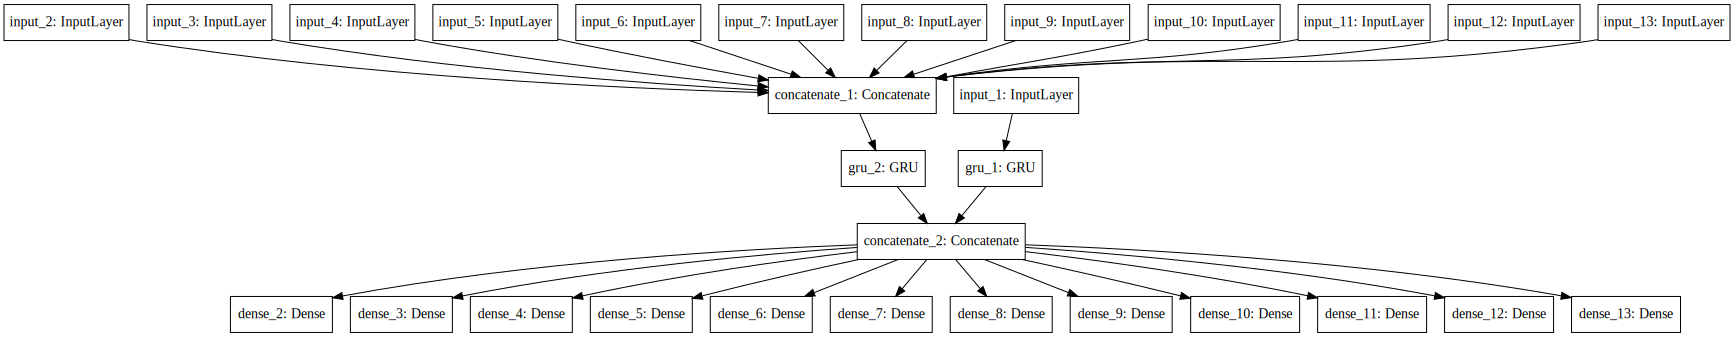

In [9]:
### Define neural net architectur ###
latent_dim = 128

melody_input = Input(shape=(max_melody_seq_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

# chords_input = Input(shape=(ch_context_window, n_chords))
# chords_gru = GRU(latent_dim)(chords_input)

C_i = Input(shape=(ch_context_window, 1))
Db_i = Input(shape=(ch_context_window, 1))
D_i = Input(shape=(ch_context_window, 1))
Eb_i = Input(shape=(ch_context_window, 1))
E_i = Input(shape=(ch_context_window, 1))
F_i = Input(shape=(ch_context_window, 1))
Gb_i = Input(shape=(ch_context_window, 1))
G_i = Input(shape=(ch_context_window, 1))
Ab_i = Input(shape=(ch_context_window, 1))
A_i = Input(shape=(ch_context_window, 1))
Bb_i = Input(shape=(ch_context_window, 1))
B_i = Input(shape=(ch_context_window, 1))

chord_notes_concat = concatenate([C_i, Db_i, D_i, Eb_i, E_i, F_i, Gb_i, G_i, Ab_i, A_i, Bb_i, B_i])

chord_notes_gru = GRU(latent_dim)(chord_notes_concat)


concat = concatenate([melody_gru, chord_notes_gru])

chord_dense = Dense(n_chords, activation='softmax')(concat)

C_o = Dense(1, activation='sigmoid')(concat)
Db_o = Dense(1, activation='sigmoid')(concat)
D_o = Dense(1, activation='sigmoid')(concat)
Eb_o = Dense(1, activation='sigmoid')(concat)
E_o = Dense(1, activation='sigmoid')(concat)
F_o = Dense(1, activation='sigmoid')(concat)
Gb_o = Dense(1, activation='sigmoid')(concat)
G_o = Dense(1, activation='sigmoid')(concat)
Ab_o = Dense(1, activation='sigmoid')(concat)
A_o = Dense(1, activation='sigmoid')(concat)
Bb_o = Dense(1, activation='sigmoid')(concat)
B_o = Dense(1, activation='sigmoid')(concat)


model = Model([melody_input, C_i, Db_i, D_i, Eb_i, E_i, F_i, Gb_i, G_i, Ab_i, A_i, Bb_i, B_i], [C_o, Db_o, D_o, Eb_o, E_o, F_o, Gb_o, G_o, Ab_o, A_o, Bb_o, B_o])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
### Train model ###
batch_size = 32
epochs = 10

# history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size)
history = model.fit([X_melody_train, X_C_train, X_Db_train, X_D_train, X_Eb_train, X_E_train, X_F_train, X_Gb_train, X_G_train, X_Ab_train, X_A_train, X_Bb_train, X_B_train],
                    [Y_C_train, Y_Db_train, Y_D_train, Y_Eb_train, Y_E_train, Y_F_train, Y_Gb_train, Y_G_train, Y_Ab_train, Y_A_train, Y_Bb_train, Y_B_train],
                    epochs=epochs, 
                    validation_data=([X_melody_valid, X_C_valid, X_Db_valid, X_D_valid, X_Eb_valid, X_E_valid, X_F_valid, X_Gb_valid, X_G_valid, X_Ab_valid, X_A_valid, X_Bb_valid, X_B_valid],
                                     [Y_C_valid, Y_Db_valid, Y_D_valid, Y_Eb_valid, Y_E_valid, Y_F_valid, Y_Gb_valid, Y_G_valid, Y_Ab_valid, Y_A_valid, Y_Bb_valid, Y_B_valid]), batch_size=batch_size)


Train on 267475 samples, validate on 33434 samples
Epoch 1/10
267475/267475 [==============================] - 1239s - loss: 5.5372 - dense_2_loss: 0.4590 - dense_3_loss: 0.4616 - dense_4_loss: 0.4586 - dense_5_loss: 0.4614 - dense_6_loss: 0.4626 - dense_7_loss: 0.4628 - dense_8_loss: 0.4621 - dense_9_loss: 0.4616 - dense_10_loss: 0.4617 - dense_11_loss: 0.4605 - dense_12_loss: 0.4624 - dense_13_loss: 0.4628 - dense_2_acc: 0.7971 - dense_3_acc: 0.7960 - dense_4_acc: 0.7971 - dense_5_acc: 0.7947 - dense_6_acc: 0.7953 - dense_7_acc: 0.7953 - dense_8_acc: 0.7942 - dense_9_acc: 0.7948 - dense_10_acc: 0.7954 - dense_11_acc: 0.7964 - dense_12_acc: 0.7955 - dense_13_acc: 0.7944 - val_loss: 5.0326 - val_dense_2_loss: 0.4141 - val_dense_3_loss: 0.4186 - val_dense_4_loss: 0.4233 - val_dense_5_loss: 0.4201 - val_dense_6_loss: 0.4139 - val_dense_7_loss: 0.4222 - val_dense_8_loss: 0.4248 - val_dense_9_loss: 0.4185 - val_dense_10_loss: 0.4149 - val_dense_11_loss: 0.4223 - val_dense_12_loss: 0.4218 -

KeyboardInterrupt: 

NameError: name 'history' is not defined

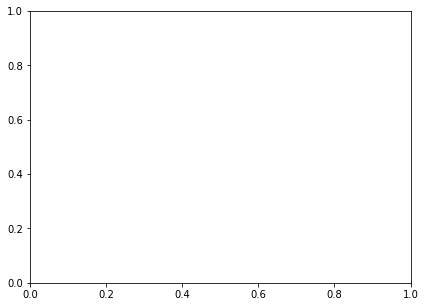

In [11]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dense_2_acc'])
plt.plot(history.history['dense_3_acc'])
plt.plot(history.history['dense_4_acc'])
plt.plot(history.history['dense_5_acc'])
plt.plot(history.history['dense_6_acc'])
plt.plot(history.history['dense_7_acc'])
plt.plot(history.history['dense_8_acc'])
plt.plot(history.history['dense_9_acc'])
plt.plot(history.history['dense_10_acc'])
plt.plot(history.history['dense_11_acc'])
plt.plot(history.history['dense_12_acc'])
plt.plot(history.history['dense_13_acc'])
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'], loc='upper left')

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)
plt.plot(history.history['val_dense_2_acc'])
plt.plot(history.history['val_dense_3_acc'])
plt.plot(history.history['val_dense_4_acc'])
plt.plot(history.history['val_dense_5_acc'])
plt.plot(history.history['val_dense_6_acc'])
plt.plot(history.history['val_dense_7_acc'])
plt.plot(history.history['val_dense_8_acc'])
plt.plot(history.history['val_dense_9_acc'])
plt.plot(history.history['val_dense_10_acc'])
plt.plot(history.history['val_dense_11_acc'])
plt.plot(history.history['val_dense_12_acc'])
plt.plot(history.history['val_dense_13_acc'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'], loc='upper left')
plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['dense_4_loss'])
plt.plot(history.history['dense_5_loss'])
plt.plot(history.history['dense_6_loss'])
plt.plot(history.history['dense_7_loss'])
plt.plot(history.history['dense_8_loss'])
plt.plot(history.history['dense_9_loss'])
plt.plot(history.history['dense_10_loss'])
plt.plot(history.history['dense_11_loss'])
plt.plot(history.history['dense_12_loss'])
plt.plot(history.history['dense_13_loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'], loc='upper left')

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)
plt.plot(history.history['val_dense_2_loss'])
plt.plot(history.history['val_dense_3_loss'])
plt.plot(history.history['val_dense_4_loss'])
plt.plot(history.history['val_dense_5_loss'])
plt.plot(history.history['val_dense_6_loss'])
plt.plot(history.history['val_dense_7_loss'])
plt.plot(history.history['val_dense_8_loss'])
plt.plot(history.history['val_dense_9_loss'])
plt.plot(history.history['val_dense_10_loss'])
plt.plot(history.history['val_dense_11_loss'])
plt.plot(history.history['val_dense_12_loss'])
plt.plot(history.history['val_dense_13_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B'], loc='upper left')




# plt.figure(figsize=(15,5))
# plt.subplot(1, 2, 1)
# plt.plot(model_history.history['dense_1_acc'])
# plt.plot(model_history.history['val_dense_1_acc'])
# plt.plot(model_history.history['dense_2_acc'])
# plt.plot(model_history.history['val_dense_2_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
# # plt.show()

# plt.subplot(1, 2, 2)
# plt.plot(model_history.history['dense_1_loss'])
# plt.plot(model_history.history['val_dense_1_loss'])
# plt.plot(model_history.history['dense_2_loss'])
# plt.plot(model_history.history['val_dense_2_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
# plt.tight_layout()
# plt.suptitle("Training history of root+suffix model", fontsize=16)
# plt.subplots_adjust(top=0.85)
# plt.show()

In [12]:
### Evaluate predictions ###
[C_pred, Db_pred, D_pred, Eb_pred, E_pred, F_pred, Gb_pred, G_pred, Ab_pred, A_pred, Bb_pred, B_pred] = model.predict([X_melody_test, X_C_test, X_Db_test, X_D_test, X_Eb_test, X_E_test, X_F_test, X_Gb_test, X_G_test, X_Ab_test, X_A_test, X_Bb_test, X_B_test])

# Build tensor of combined predictions
# chord_pred = np.zeros((len(test_index), n_chords), dtype='float32')
# for i, (root_softmax, suffix_softmax) in enumerate(zip(root_pred, suffix_pred)):
#     root_index = np.argmax(root_softmax)
#     suffix_index = np.argmax(suffix_softmax)
#     root_str = index_roots[root_index]
#     suffix_str = index_suffixes[suffix_index]
#     label = root_str + suffix_str if not root_str == 'NC' else 'NC' 
#     chord_pred[i, chords_index[label]] = 1
    

# Compute accuracy and kappa score 
# print("Categorical accuracy of root prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_roots_test, harmoutil.softmax_to_argmax(root_pred))))
# print("Categorical accuracy of suffix prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_suffixes_test, harmoutil.softmax_to_argmax(suffix_pred))))
# print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_chords_test, chord_pred)))
print("Categorical accuracy of C note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_C_test, harmoutil.softmax_to_argmax(C_pred))))
print("Categorical accuracy of Db note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_Db_test, harmoutil.softmax_to_argmax(Db_pred))))
print("Categorical accuracy of D note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_D_test, harmoutil.softmax_to_argmax(D_pred))))
print("Categorical accuracy of Eb note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_Eb_test, harmoutil.softmax_to_argmax(Eb_pred))))
print("Categorical accuracy of E note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_E_test, harmoutil.softmax_to_argmax(E_pred))))
print("Categorical accuracy of F note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_F_test, harmoutil.softmax_to_argmax(F_pred))))
print("Categorical accuracy of Gb note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_Gb_test, harmoutil.softmax_to_argmax(Gb_pred))))
print("Categorical accuracy of G note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_G_test, harmoutil.softmax_to_argmax(G_pred))))
print("Categorical accuracy of Ab note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_Ab_test, harmoutil.softmax_to_argmax(Ab_pred))))
print("Categorical accuracy of A note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_A_test, harmoutil.softmax_to_argmax(A_pred))))
print("Categorical accuracy of Bb note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_Bb_test, harmoutil.softmax_to_argmax(Bb_pred))))
print("Categorical accuracy of B note: {0:.4f}".format(harmoutil.compute_binary_accuracy_score(Y_B_test, harmoutil.softmax_to_argmax(B_pred))))

# print("Kappa score of root prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_roots_test, harmoutil.softmax_to_argmax(root_pred))))
# print("Kappa score of suffix prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_suffixes_test, harmoutil.softmax_to_argmax(suffix_pred))))
# print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_chords_test, chord_pred)))

print("Kappa score of C note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_C_test, harmoutil.softmax_to_argmax(C_pred))))
print("Kappa score of Db note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_Db_test, harmoutil.softmax_to_argmax(Db_pred))))
print("Kappa score of D note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_D_test, harmoutil.softmax_to_argmax(D_pred))))
print("Kappa score of Eb note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_Eb_test, harmoutil.softmax_to_argmax(Eb_pred))))
print("Kappa score of E note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_E_test, harmoutil.softmax_to_argmax(E_pred))))
print("Kappa score of F note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_F_test, harmoutil.softmax_to_argmax(F_pred))))
print("Kappa score of Gb note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_Gb_test, harmoutil.softmax_to_argmax(Gb_pred))))
print("Kappa score of G note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_G_test, harmoutil.softmax_to_argmax(G_pred))))
print("Kappa score of Ab note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_Ab_test, harmoutil.softmax_to_argmax(Ab_pred))))
print("Kappa score of A note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_A_test, harmoutil.softmax_to_argmax(A_pred))))
print("Kappa score of Bb note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_Bb_test, harmoutil.softmax_to_argmax(Bb_pred))))
print("Kappa score of B note: {0:.4f}".format(harmoutil.compute_binary_kappa_score(Y_B_test, harmoutil.softmax_to_argmax(B_pred))))

Categorical accuracy of C note: 0.2507
Categorical accuracy of Db note: 0.2514
Categorical accuracy of D note: 0.2458
Categorical accuracy of Eb note: 0.2519
Categorical accuracy of E note: 0.2536
Categorical accuracy of F note: 0.2472
Categorical accuracy of Gb note: 0.2499
Categorical accuracy of G note: 0.2473
Categorical accuracy of Ab note: 0.2493
Categorical accuracy of A note: 0.2517
Categorical accuracy of Bb note: 0.2488
Categorical accuracy of B note: 0.2482
Kappa score of C note: 0.0000
Kappa score of Db note: 0.0000
Kappa score of D note: 0.0000
Kappa score of Eb note: 0.0000
Kappa score of E note: 0.0000
Kappa score of F note: 0.0000
Kappa score of Gb note: 0.0000
Kappa score of G note: 0.0000
Kappa score of Ab note: 0.0000
Kappa score of A note: 0.0000
Kappa score of Bb note: 0.0000
Kappa score of B note: 0.0000


In [28]:
print(C_pred[:20])
print(Y_C_test[:20])

[[0.9248009 ]
 [0.27760816]
 [0.16008492]
 [0.3614969 ]
 [0.15764967]
 [0.27611992]
 [0.26051548]
 [0.31356373]
 [0.30561674]
 [0.21114239]
 [0.16400698]
 [0.21813808]
 [0.2838811 ]
 [0.19517714]
 [0.24936353]
 [0.3706341 ]
 [0.07244121]
 [0.03874298]
 [0.1618349 ]
 [0.18321523]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [29]:
print(C_pred.shape)
print(Y_C_test.shape)

(33435, 1)
(33435, 1)
